# Eye state detection classifier comparison

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd

random_seed = 123
np.random.seed(random_seed)

import warnings
warnings.filterwarnings('ignore')

In [9]:
train = pd.read_csv("train.csv")

X = train.sample(frac=1).copy()
y = X.pop("eyeDetection")

### Preprocess features

First we remove the outliers and fit a StandardScaler on the train set. 

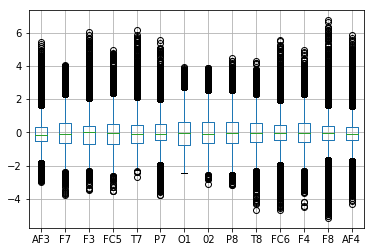

In [10]:
from scipy import stats
from sklearn import preprocessing

nonoutliers = (np.abs(stats.zscore(X)) < 3).all(axis=1)
X_clean = X[nonoutliers]
y_clean = y[nonoutliers]

scaler = preprocessing.StandardScaler()
scaler.fit(X_clean)
X_norm = pd.DataFrame(scaler.transform(X_clean),columns=X_clean.columns)

X_norm.boxplot()

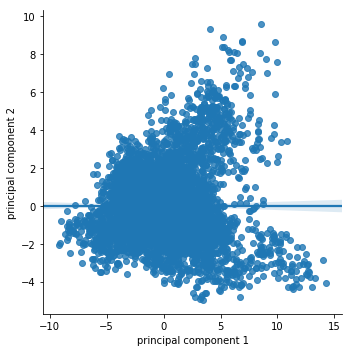

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_norm)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
sns.lmplot(x="principal component 1",y="principal component 2",data=principalDf)

In [19]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=50).fit_transform(X_norm)
X_embedded

array([[-23.51708  , -14.7410145],
       [-35.320698 ,  -5.5327706],
       [ 60.49495  ,  -2.56737  ],
       ...,
       [ 44.228848 ,   5.164534 ],
       [-55.130188 ,  40.631115 ],
       [-16.241976 ,  36.412266 ]], dtype=float32)

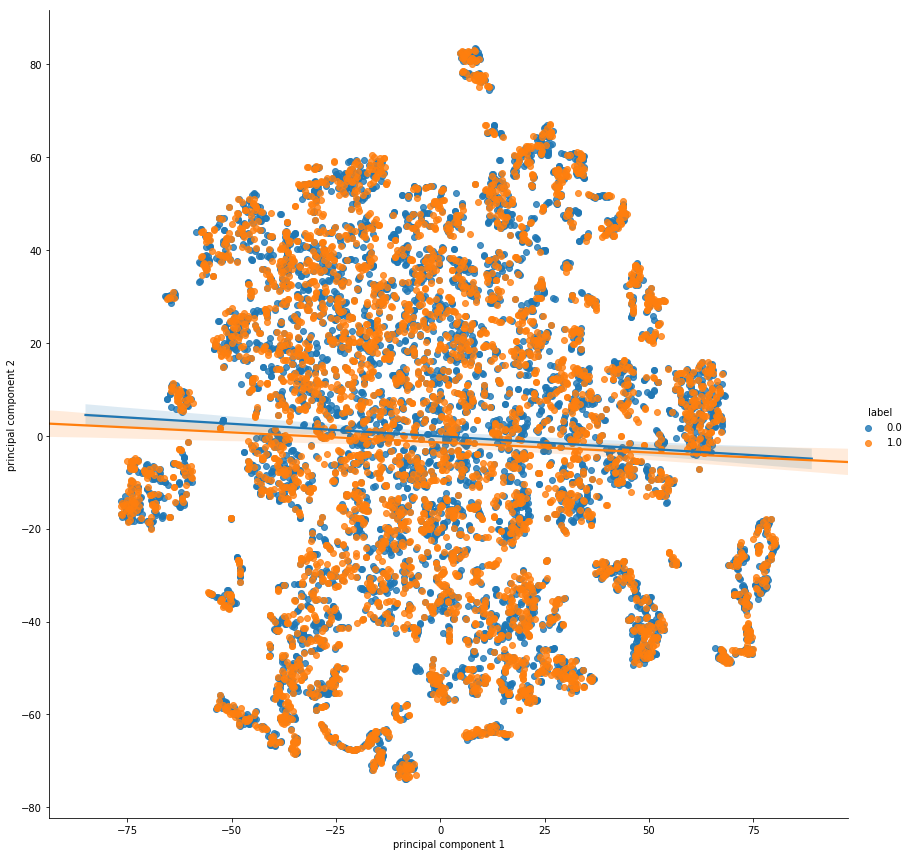

In [20]:
principalDf = pd.DataFrame(data = X_embedded
             , columns = ['principal component 1', 'principal component 2'])
principalDf["label"] = y_clean
sns.lmplot(x="principal component 1",y="principal component 2",hue="label",data=principalDf,height=12)

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30, random_state=0).fit(principalDf[['principal component 1', 'principal component 2']])
principalDf["kmeans"] = kmeans.labels_

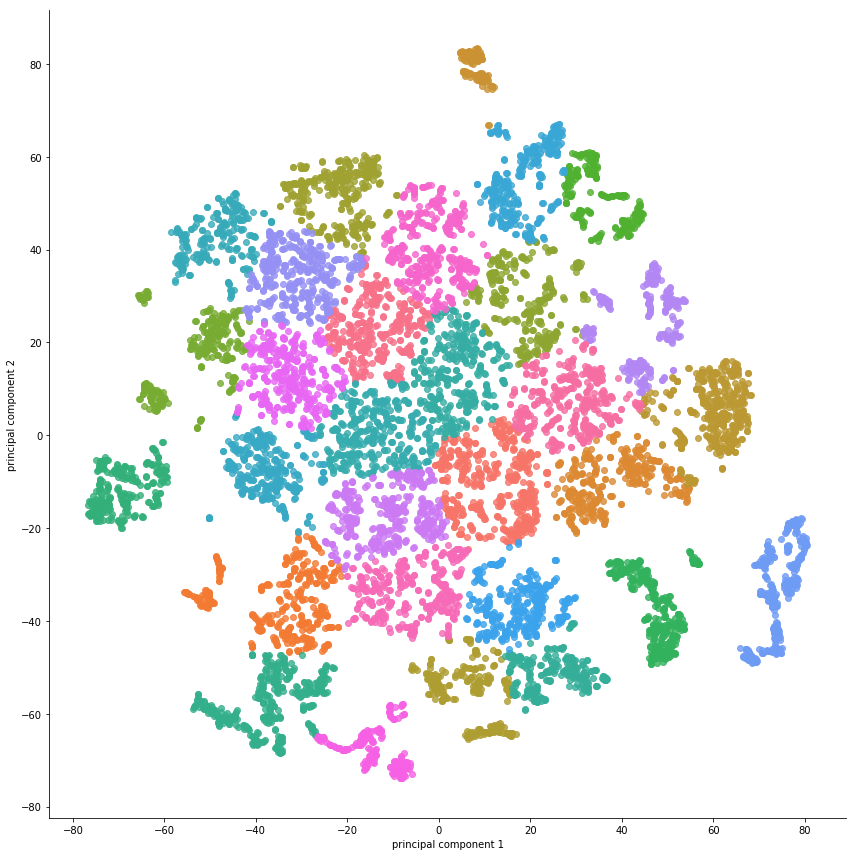

In [32]:
sns.lmplot(x="principal component 1",y="principal component 2",hue="kmeans",fit_reg=False,legend=False,data=principalDf,height=12)

Then we apply **the fitted** StandardScaler on the test set.

In [4]:
test = pd.read_csv("test.csv")

index_col = test.pop("index")
X_test = scaler.transform(test)

Next we evaluate some Machine Learning algorithms.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "LR": LogisticRegression(solver='lbfgs'),
    "SVM": SVC(probability=True), #make sure to output probabilities
    "RF": RandomForestClassifier(),
    "GB": GradientBoostingClassifier()
}

hyperparams = {
    "LR":{
        "C":[0.001,0.01,0.1,1,10]
    },
    "SVM":{
        "kernel":['rbf'],
        "C":[0.001,0.01,0.1,1,10],
        "gamma":[0.01,0.05,0.1,0.5]
    },
    "RF":{
        "n_estimators":[100],
        "max_features":[3,6,9,12,14]
    },
    "GB":{
        "n_estimators":[100,200,300],
        "learning_rate":[0.01,0.1,0.3],
        "max_depth":[3,6,9]
    }    
}

I split the training set in a 90% train and 10% validation part.

In [6]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=.1, random_state=random_seed)

Then I optimize the hyperparameters on the 90% train part using 3-fold cross-validation.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

CV = 3

for cls_name in classifiers:
    cls = GridSearchCV(classifiers[cls_name],hyperparams[cls_name],cv=CV,scoring="roc_auc",verbose=3)
    cls.fit(train_X,train_y)
    predictions = cls.best_estimator_.predict_proba(val_X)
    print("%s\tCV=%f\tVAL=%f"%(cls_name,cls.best_score_,roc_auc_score(val_y,predictions[:,1])))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.001 .........................................................
[CV] ................. C=0.001, score=0.680198389720621, total=   0.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................ C=0.001, score=0.6716962294201836, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.6535055713011275, total=   0.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ................. C=0.01, score=0.6823239297957302, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6750193200334955, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.6617332368714598, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.6763514268119455, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.6752162206650576, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.6597615394310334, total=   0.1s
[CV] C=1 .............................................................
[CV] .................... C=1, score=0.6810393662221677, total=   0.0s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LR	CV=0.673025	VAL=0.686018
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.9819586993076184, total=   8.9s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.9867018067763419, total=   8.8s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.0s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.9856083130639307, total=   9.5s
[CV] C=0.001, gamma=0.05, kernel=rbf .................................
[CV]  C=0.001, gamma=0.05, kernel=rbf, score=0.9698015430012591, total=  11.6s
[CV] C=0.001, gamma=0.05, kernel=rbf .................................
[CV]  C=0.001, gamma=0.05, kernel=rbf, score=0.9731336040305875, total=  11.4s
[CV] C=0.001, gamma=0.05, kernel=rbf .................................
[CV]  C=0.001, gamma=0.05, kernel=rbf, score=0.9718023942937389, total=  12.2s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.8848745778858613, total=  13.9s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.9034251739475796, total=  14.3s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.9093678502981093, total=  13.9s
[CV] C=0.001, gamma=0.5,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Work\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-3191799a8c1b>", line 8, in <module>
    cls.fit(train_X,train_y)
  File "C:\Users\Work\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 722, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\Work\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1191, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\Work\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 711, in evaluate_candidates
    cv.split(X, y, groups)))
  File "C:\Users\Work\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line 920, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\Work\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py", line

KeyboardInterrupt: 